# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data 

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative". 

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
from bs4 import BeautifulSoup

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras import regularizers
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 40000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (40000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

# [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(37415, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

93.5375

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions 

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(37415, 10)


1    31324
0     6091
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.
It's Branston pickle, what is there to say. If you've never tried it you most likely wont like it. If you grew up in the UK its a staple on cheese of cold meat sandwiches. It's on my lunch sandwich today! :)
First Impression: The friendly folks over at "Exclusively Dog" heard about my website and sent me 5 of their products to test.<br />Let me just start off by saying that I Love how sweet all of these treats taste. Dad was/is considering trying one because they look and smell so much like human cookies. Plus the ingredients are very straight forward, they are probably healthier than most the stuff Mom eats... But there in lies the problem. Dad thinks that they are too sweet for a puppy of any age. The second ingredient in almost all of them is sugar. As we all know puppies have a hard time processing sugar, and just like humans can dev

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element


soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.
It's Branston pickle, what is there to say. If you've never tried it you most likely wont like it. If you grew up in the UK its a staple on cheese of cold meat sandwiches. It's on my lunch sandwich today! :)
First Impression: The friendly folks over at "Exclusively Dog" heard about my website and sent me 5 of their products to test.Let me just start off by saying that I Love how sweet all of these treats taste. Dad was/is considering trying one because they look and smell so much like human cookies. Plus the ingredients are very straight forward, they are probably healthier than most the stuff Mom eats... But there in lies the problem. Dad thinks that they are too sweet for a puppy of any age. The second ingredient in almost all of them is sugar. As we all know puppies have a hard time processing sugar, and just like humans can develop d

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

First Impression: The friendly folks over at "Exclusively Dog" heard about my website and sent me 5 of their products to test.<br />Let me just start off by saying that I Love how sweet all of these treats taste. Dad was/is considering trying one because they look and smell so much like human cookies. Plus the ingredients are very straight forward, they are probably healthier than most the stuff Mom eats... But there in lies the problem. Dad thinks that they are too sweet for a puppy of any age. The second ingredient in almost all of them is sugar. As we all know puppies have a hard time processing sugar, and just like humans can develop diabetes.<br /><br />Conclusion: Your puppy is nearly guaranteed to LOVE the taste. However these should only be used as an occasional treat! If you were to feed your puppies these sugary sweet morsels every day, they would soon plump up. If you puppy is already overweight or does not exercise regularly, you may want to think twice. On the PRO side the

In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

First Impression The friendly folks over at Exclusively Dog heard about my website and sent me 5 of their products to test br Let me just start off by saying that I Love how sweet all of these treats taste Dad was is considering trying one because they look and smell so much like human cookies Plus the ingredients are very straight forward they are probably healthier than most the stuff Mom eats But there in lies the problem Dad thinks that they are too sweet for a puppy of any age The second ingredient in almost all of them is sugar As we all know puppies have a hard time processing sugar and just like humans can develop diabetes br br Conclusion Your puppy is nearly guaranteed to LOVE the taste However these should only be used as an occasional treat If you were to feed your puppies these sugary sweet morsels every day they would soon plump up If you puppy is already overweight or does not exercise regularly you may want to think twice On the PRO side they are all natural with no ani

In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 37415/37415 [00:11<00:00, 3118.64it/s]


In [23]:
preprocessed_reviews[1500]

'first impression friendly folks exclusively dog heard website sent products test let start saying love sweet treats taste dad considering trying one look smell much like human cookies plus ingredients straight forward probably healthier stuff mom eats lies problem dad thinks sweet puppy age second ingredient almost sugar know puppies hard time processing sugar like humans develop diabetes conclusion puppy nearly guaranteed love taste however used occasional treat feed puppies sugary sweet morsels every day would soon plump puppy already overweight not exercise regularly may want think twice pro side natural no animal bi products paws dad made judging taste alone would'

In [24]:
x = preprocessed_reviews
y = final["Score"].values

In [25]:
print(type(x))
print(len(x))
print(len(y))
print(y)

<class 'list'>
37415
37415
[1 0 1 ... 0 0 1]


### Converting data like Imdb dataset 

In [26]:
from sklearn.model_selection import train_test_split 
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2, random_state=42)    

In [27]:
type(X_train)
print(len(X_train))
print(len(X_test))

29932
7483


In [28]:
from keras.preprocessing.text import Tokenizer
max_features = 5000
tokenizer = Tokenizer(num_words=max_features, lower = False)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)

In [29]:
X_test = tokenizer.texts_to_sequences(X_test)

In [30]:
print(X_train[45])
print(type(X_train[45]))
print(len(X_train[45]))

[8, 209, 1001, 8, 36, 146, 8, 1, 790, 882, 4079, 510, 20, 8, 219, 344, 8, 1422, 70, 3829, 1795, 168, 3356, 81, 730, 761, 7, 1, 56, 8, 3991, 310]
<class 'list'>
32


In [31]:
# truncate and/or pad input sequences
max_review_length = 600
X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)

print(X_train.shape)
print(X_train[45])

(29932, 600)
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    

In [32]:
print("shape of training data: ", X_train.shape)
print("shape of testing data: ", X_test.shape)

shape of training data:  (29932, 600)
shape of testing data:  (7483, 600)


# Model 1

In [36]:
# create the model

import warnings 
warnings.filterwarnings("ignore")

embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(max_features, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100, kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01)))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 600, 32)           160000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 213,301
Trainable params: 213,301
Non-trainable params: 0
_________________________________________________________________
None


#### Using Earlystopping to reduce overfitting 

In [37]:
# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=1)

In [38]:
import warnings 
warnings.filterwarnings("ignore")

history = model.fit(X_train, Y_train, epochs = 10,verbose = 1, batch_size = 128,validation_data=(X_test, Y_test),callbacks = [es])
scores = model.evaluate(X_test, Y_test, verbose = 0)
print("Accuracy: %.2f%%" % (scores[1]*100))


Train on 29932 samples, validate on 7483 samples
Epoch 1/10


25984/29932 [=========================>....] - ETA: 19:53 - loss: 1.3026 - acc: 0.58 - ETA: 16:32 - loss: 1.2925 - acc: 0.70 - ETA: 15:36 - loss: 1.2822 - acc: 0.76 - ETA: 15:11 - loss: 1.2714 - acc: 0.78 - ETA: 14:52 - loss: 1.2606 - acc: 0.80 - ETA: 14:42 - loss: 1.2508 - acc: 0.79 - ETA: 14:29 - loss: 1.2403 - acc: 0.79 - ETA: 14:25 - loss: 1.2283 - acc: 0.79 - ETA: 14:22 - loss: 1.2131 - acc: 0.80 - ETA: 14:19 - loss: 1.1945 - acc: 0.81 - ETA: 14:21 - loss: 1.1745 - acc: 0.81 - ETA: 14:16 - loss: 1.1636 - acc: 0.80 - ETA: 14:21 - loss: 1.1371 - acc: 0.81 - ETA: 14:13 - loss: 1.1231 - acc: 0.81 - ETA: 14:12 - loss: 1.0994 - acc: 0.81 - ETA: 14:09 - loss: 1.0804 - acc: 0.82 - ETA: 14:07 - loss: 1.0688 - acc: 0.82 - ETA: 14:04 - loss: 1.0564 - acc: 0.82 - ETA: 14:01 - loss: 1.0462 - acc: 0.82 - ETA: 13:59 - loss: 1.0324 - acc: 0.82 - ETA: 13:58 - loss: 1.0186 - acc: 0.82 - ETA: 13:56 - loss: 1.0039 - acc: 0.83 - ETA: 13:53 - loss: 0.9957 - acc: 0.83 - ETA: 13:51 - loss: 0.9872 - acc: 

26112/29932 [=========================>....] - ETA: 22:33 - loss: 0.2536 - acc: 0.92 - ETA: 22:39 - loss: 0.2990 - acc: 0.90 - ETA: 22:40 - loss: 0.2861 - acc: 0.91 - ETA: 22:22 - loss: 0.2804 - acc: 0.91 - ETA: 22:19 - loss: 0.2846 - acc: 0.92 - ETA: 22:14 - loss: 0.2780 - acc: 0.92 - ETA: 22:14 - loss: 0.2704 - acc: 0.91 - ETA: 22:09 - loss: 0.2587 - acc: 0.92 - ETA: 22:04 - loss: 0.2631 - acc: 0.91 - ETA: 21:58 - loss: 0.2764 - acc: 0.91 - ETA: 21:57 - loss: 0.2768 - acc: 0.90 - ETA: 21:53 - loss: 0.2767 - acc: 0.90 - ETA: 21:49 - loss: 0.2778 - acc: 0.90 - ETA: 21:41 - loss: 0.2795 - acc: 0.90 - ETA: 21:37 - loss: 0.2818 - acc: 0.90 - ETA: 21:31 - loss: 0.2799 - acc: 0.90 - ETA: 21:26 - loss: 0.2800 - acc: 0.90 - ETA: 21:21 - loss: 0.2827 - acc: 0.90 - ETA: 21:15 - loss: 0.2804 - acc: 0.90 - ETA: 21:11 - loss: 0.2780 - acc: 0.90 - ETA: 21:07 - loss: 0.2816 - acc: 0.90 - ETA: 21:01 - loss: 0.2805 - acc: 0.90 - ETA: 20:55 - loss: 0.2803 - acc: 0.90 - ETA: 20:51 - loss: 0.2808 - acc: 

29932/29932 [==============================] - ETA: 2:55 - loss: 0.2663 - acc: 0.912 - ETA: 2:49 - loss: 0.2666 - acc: 0.912 - ETA: 2:43 - loss: 0.2664 - acc: 0.912 - ETA: 2:37 - loss: 0.2664 - acc: 0.912 - ETA: 2:31 - loss: 0.2666 - acc: 0.912 - ETA: 2:25 - loss: 0.2663 - acc: 0.912 - ETA: 2:19 - loss: 0.2662 - acc: 0.912 - ETA: 2:13 - loss: 0.2663 - acc: 0.912 - ETA: 2:07 - loss: 0.2663 - acc: 0.912 - ETA: 2:01 - loss: 0.2662 - acc: 0.912 - ETA: 1:54 - loss: 0.2659 - acc: 0.912 - ETA: 1:48 - loss: 0.2656 - acc: 0.912 - ETA: 1:42 - loss: 0.2651 - acc: 0.913 - ETA: 1:36 - loss: 0.2650 - acc: 0.913 - ETA: 1:30 - loss: 0.2648 - acc: 0.913 - ETA: 1:24 - loss: 0.2645 - acc: 0.913 - ETA: 1:18 - loss: 0.2644 - acc: 0.913 - ETA: 1:12 - loss: 0.2641 - acc: 0.913 - ETA: 1:06 - loss: 0.2638 - acc: 0.913 - ETA: 1:00 - loss: 0.2641 - acc: 0.913 - ETA: 53s - loss: 0.2639 - acc: 0.913 - ETA: 47s - loss: 0.2638 - acc: 0.91 - ETA: 41s - loss: 0.2638 - acc: 0.91 - ETA: 35s - loss: 0.2639 - acc: 0.91 - 

26112/29932 [=========================>....] - ETA: 24:11 - loss: 0.1833 - acc: 0.95 - ETA: 24:03 - loss: 0.2031 - acc: 0.94 - ETA: 23:52 - loss: 0.1916 - acc: 0.94 - ETA: 23:40 - loss: 0.1954 - acc: 0.94 - ETA: 23:29 - loss: 0.2114 - acc: 0.93 - ETA: 23:31 - loss: 0.2180 - acc: 0.93 - ETA: 23:23 - loss: 0.2173 - acc: 0.93 - ETA: 23:17 - loss: 0.2176 - acc: 0.93 - ETA: 23:15 - loss: 0.2202 - acc: 0.93 - ETA: 22:55 - loss: 0.2241 - acc: 0.93 - ETA: 22:49 - loss: 0.2238 - acc: 0.93 - ETA: 22:45 - loss: 0.2217 - acc: 0.93 - ETA: 22:41 - loss: 0.2186 - acc: 0.93 - ETA: 22:36 - loss: 0.2156 - acc: 0.93 - ETA: 22:30 - loss: 0.2209 - acc: 0.93 - ETA: 22:24 - loss: 0.2216 - acc: 0.93 - ETA: 22:18 - loss: 0.2179 - acc: 0.93 - ETA: 22:12 - loss: 0.2195 - acc: 0.93 - ETA: 22:07 - loss: 0.2193 - acc: 0.93 - ETA: 22:03 - loss: 0.2187 - acc: 0.93 - ETA: 21:56 - loss: 0.2179 - acc: 0.93 - ETA: 21:52 - loss: 0.2187 - acc: 0.93 - ETA: 21:46 - loss: 0.2187 - acc: 0.93 - ETA: 21:39 - loss: 0.2189 - acc: 

In [39]:
print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


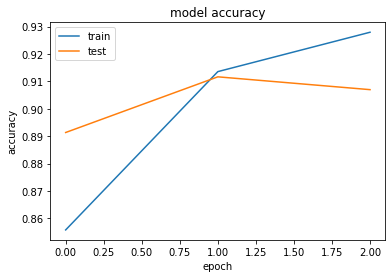

In [40]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

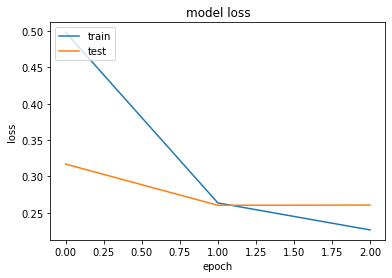

In [41]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [42]:
print('Test score:', scores[0]) 
print('Test accuracy:', scores[1]) 

Test score: 0.2606846533260705
Test accuracy: 0.906989175488282


### Model 2 

In [34]:
embedding_vecor_length = 32
model_2 = Sequential()
model_2.add(Embedding(max_features, embedding_vecor_length, input_length=max_review_length))
model_2.add(LSTM(100, return_sequences=True, kernel_regularizer=regularizers.l2(0.01)))
model_2.add(LSTM(100, kernel_regularizer=regularizers.l2(0.01)))
model_2.add(Dropout(0.30))
model_2.add(Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01)))
model_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_2.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 600, 32)           160000    
_________________________________________________________________
lstm_3 (LSTM)                (None, 600, 100)          53200     
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 293,701
Trainable params: 293,701
Non-trainable params: 0
_________________________________________________________________
None


#### Using Earlystopping to reduce overfitting 

In [35]:
# simple early stopping
es1 = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [36]:
history = model_2.fit(X_train, Y_train, epochs = 7,verbose = 1, batch_size = 128,validation_data=(X_test, Y_test),callbacks = [es1])
scores_2 = model_2.evaluate(X_test, Y_test, verbose = 0)
print("Accuracy: %.2f%%" % (scores_2[1]*100))

Train on 29932 samples, validate on 7483 samples
Epoch 1/7


25984/29932 [=========================>....] - ETA: 25:45 - loss: 2.8962 - acc: 0.47 - ETA: 22:00 - loss: 2.8721 - acc: 0.64 - ETA: 21:02 - loss: 2.8455 - acc: 0.70 - ETA: 20:26 - loss: 2.8171 - acc: 0.74 - ETA: 20:04 - loss: 2.7875 - acc: 0.77 - ETA: 19:47 - loss: 2.7577 - acc: 0.78 - ETA: 19:36 - loss: 2.7266 - acc: 0.78 - ETA: 19:23 - loss: 2.6940 - acc: 0.79 - ETA: 19:15 - loss: 2.6569 - acc: 0.79 - ETA: 19:15 - loss: 2.6181 - acc: 0.80 - ETA: 19:13 - loss: 2.5728 - acc: 0.80 - ETA: 19:13 - loss: 2.5496 - acc: 0.80 - ETA: 19:17 - loss: 2.5246 - acc: 0.80 - ETA: 19:14 - loss: 2.4928 - acc: 0.80 - ETA: 19:10 - loss: 2.4592 - acc: 0.80 - ETA: 19:05 - loss: 2.4304 - acc: 0.80 - ETA: 19:01 - loss: 2.3993 - acc: 0.80 - ETA: 18:58 - loss: 2.3673 - acc: 0.81 - ETA: 18:52 - loss: 2.3382 - acc: 0.81 - ETA: 18:47 - loss: 2.3092 - acc: 0.81 - ETA: 18:42 - loss: 2.2819 - acc: 0.81 - ETA: 18:38 - loss: 2.2552 - acc: 0.82 - ETA: 18:32 - loss: 2.2316 - acc: 0.81 - ETA: 18:32 - loss: 2.2060 - acc: 

29932/29932 [==============================] - ETA: 2:49 - loss: 0.7837 - acc: 0.854 - ETA: 2:43 - loss: 0.7812 - acc: 0.854 - ETA: 2:38 - loss: 0.7794 - acc: 0.854 - ETA: 2:32 - loss: 0.7770 - acc: 0.854 - ETA: 2:26 - loss: 0.7748 - acc: 0.854 - ETA: 2:21 - loss: 0.7726 - acc: 0.855 - ETA: 2:15 - loss: 0.7704 - acc: 0.855 - ETA: 2:10 - loss: 0.7677 - acc: 0.855 - ETA: 2:04 - loss: 0.7655 - acc: 0.855 - ETA: 1:58 - loss: 0.7635 - acc: 0.856 - ETA: 1:53 - loss: 0.7614 - acc: 0.856 - ETA: 1:47 - loss: 0.7591 - acc: 0.856 - ETA: 1:41 - loss: 0.7573 - acc: 0.856 - ETA: 1:36 - loss: 0.7550 - acc: 0.857 - ETA: 1:30 - loss: 0.7528 - acc: 0.857 - ETA: 1:24 - loss: 0.7504 - acc: 0.857 - ETA: 1:19 - loss: 0.7481 - acc: 0.857 - ETA: 1:13 - loss: 0.7459 - acc: 0.858 - ETA: 1:07 - loss: 0.7440 - acc: 0.858 - ETA: 1:02 - loss: 0.7423 - acc: 0.858 - ETA: 56s - loss: 0.7404 - acc: 0.858 - ETA: 50s - loss: 0.7383 - acc: 0.85 - ETA: 45s - loss: 0.7368 - acc: 0.85 - ETA: 39s - loss: 0.7349 - acc: 0.85 - 

26112/29932 [=========================>....] - ETA: 24:22 - loss: 0.2314 - acc: 0.89 - ETA: 24:08 - loss: 0.2804 - acc: 0.88 - ETA: 24:08 - loss: 0.2727 - acc: 0.90 - ETA: 24:00 - loss: 0.2621 - acc: 0.91 - ETA: 24:06 - loss: 0.2600 - acc: 0.91 - ETA: 24:42 - loss: 0.2667 - acc: 0.91 - ETA: 24:34 - loss: 0.2657 - acc: 0.91 - ETA: 24:48 - loss: 0.2567 - acc: 0.91 - ETA: 24:39 - loss: 0.2567 - acc: 0.91 - ETA: 24:28 - loss: 0.2578 - acc: 0.91 - ETA: 24:23 - loss: 0.2566 - acc: 0.91 - ETA: 24:11 - loss: 0.2532 - acc: 0.91 - ETA: 24:01 - loss: 0.2618 - acc: 0.91 - ETA: 23:51 - loss: 0.2623 - acc: 0.91 - ETA: 23:41 - loss: 0.2604 - acc: 0.91 - ETA: 23:33 - loss: 0.2620 - acc: 0.91 - ETA: 23:33 - loss: 0.2605 - acc: 0.91 - ETA: 23:25 - loss: 0.2607 - acc: 0.91 - ETA: 23:18 - loss: 0.2607 - acc: 0.91 - ETA: 23:09 - loss: 0.2605 - acc: 0.91 - ETA: 22:59 - loss: 0.2587 - acc: 0.91 - ETA: 22:52 - loss: 0.2569 - acc: 0.91 - ETA: 22:44 - loss: 0.2616 - acc: 0.91 - ETA: 22:37 - loss: 0.2595 - acc: 

29932/29932 [==============================] - ETA: 4:57 - loss: 0.2605 - acc: 0.914 - ETA: 4:50 - loss: 0.2605 - acc: 0.914 - ETA: 4:42 - loss: 0.2603 - acc: 0.914 - ETA: 4:35 - loss: 0.2604 - acc: 0.914 - ETA: 4:26 - loss: 0.2607 - acc: 0.914 - ETA: 4:18 - loss: 0.2605 - acc: 0.914 - ETA: 4:10 - loss: 0.2606 - acc: 0.914 - ETA: 4:01 - loss: 0.2606 - acc: 0.914 - ETA: 3:52 - loss: 0.2605 - acc: 0.914 - ETA: 3:43 - loss: 0.2603 - acc: 0.914 - ETA: 3:34 - loss: 0.2602 - acc: 0.914 - ETA: 3:24 - loss: 0.2604 - acc: 0.914 - ETA: 3:14 - loss: 0.2604 - acc: 0.914 - ETA: 3:04 - loss: 0.2602 - acc: 0.914 - ETA: 2:54 - loss: 0.2603 - acc: 0.914 - ETA: 2:43 - loss: 0.2600 - acc: 0.914 - ETA: 2:32 - loss: 0.2599 - acc: 0.914 - ETA: 2:22 - loss: 0.2596 - acc: 0.914 - ETA: 2:11 - loss: 0.2596 - acc: 0.914 - ETA: 1:59 - loss: 0.2595 - acc: 0.914 - ETA: 1:48 - loss: 0.2594 - acc: 0.914 - ETA: 1:36 - loss: 0.2592 - acc: 0.914 - ETA: 1:25 - loss: 0.2592 - acc: 0.914 - ETA: 1:13 - loss: 0.2597 - acc: 0

25344/29932 [========================>.....] - ETA: 2:05:36 - loss: 0.2004 - acc: 0.94 - ETA: 2:03:39 - loss: 0.2321 - acc: 0.93 - ETA: 2:03:10 - loss: 0.2119 - acc: 0.93 - ETA: 2:01:41 - loss: 0.2123 - acc: 0.93 - ETA: 2:01:02 - loss: 0.2173 - acc: 0.92 - ETA: 2:00:47 - loss: 0.2088 - acc: 0.93 - ETA: 2:00:26 - loss: 0.2111 - acc: 0.93 - ETA: 1:59:56 - loss: 0.2120 - acc: 0.92 - ETA: 1:59:26 - loss: 0.2114 - acc: 0.93 - ETA: 1:58:57 - loss: 0.2133 - acc: 0.93 - ETA: 1:58:37 - loss: 0.2066 - acc: 0.93 - ETA: 1:58:22 - loss: 0.2097 - acc: 0.93 - ETA: 1:58:02 - loss: 0.2099 - acc: 0.93 - ETA: 1:57:35 - loss: 0.2084 - acc: 0.93 - ETA: 1:57:18 - loss: 0.2064 - acc: 0.93 - ETA: 1:56:39 - loss: 0.2072 - acc: 0.93 - ETA: 1:56:18 - loss: 0.2073 - acc: 0.93 - ETA: 1:55:53 - loss: 0.2060 - acc: 0.93 - ETA: 1:55:24 - loss: 0.2042 - acc: 0.93 - ETA: 1:55:00 - loss: 0.2037 - acc: 0.93 - ETA: 1:54:32 - loss: 0.2024 - acc: 0.93 - ETA: 1:53:53 - loss: 0.2058 - acc: 0.93 - ETA: 1:53:19 - loss: 0.2107 -

29932/29932 [==============================] - ETA: 18:59 - loss: 0.2407 - acc: 0.92 - ETA: 18:26 - loss: 0.2405 - acc: 0.92 - ETA: 17:53 - loss: 0.2404 - acc: 0.92 - ETA: 17:21 - loss: 0.2404 - acc: 0.92 - ETA: 16:48 - loss: 0.2402 - acc: 0.92 - ETA: 16:16 - loss: 0.2400 - acc: 0.92 - ETA: 15:43 - loss: 0.2396 - acc: 0.92 - ETA: 15:11 - loss: 0.2392 - acc: 0.92 - ETA: 14:38 - loss: 0.2394 - acc: 0.92 - ETA: 14:05 - loss: 0.2393 - acc: 0.92 - ETA: 13:32 - loss: 0.2400 - acc: 0.92 - ETA: 12:59 - loss: 0.2398 - acc: 0.92 - ETA: 12:27 - loss: 0.2402 - acc: 0.92 - ETA: 11:54 - loss: 0.2400 - acc: 0.92 - ETA: 11:21 - loss: 0.2398 - acc: 0.92 - ETA: 10:49 - loss: 0.2400 - acc: 0.92 - ETA: 10:16 - loss: 0.2399 - acc: 0.92 - ETA: 9:43 - loss: 0.2399 - acc: 0.9214 - ETA: 9:11 - loss: 0.2397 - acc: 0.921 - ETA: 8:38 - loss: 0.2393 - acc: 0.921 - ETA: 8:05 - loss: 0.2395 - acc: 0.921 - ETA: 7:33 - loss: 0.2394 - acc: 0.921 - ETA: 7:00 - loss: 0.2397 - acc: 0.921 - ETA: 6:27 - loss: 0.2396 - acc: 

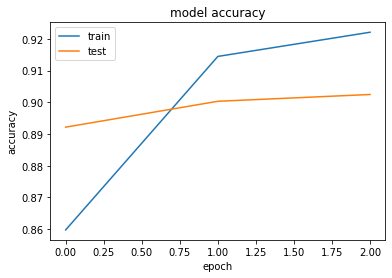

In [37]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

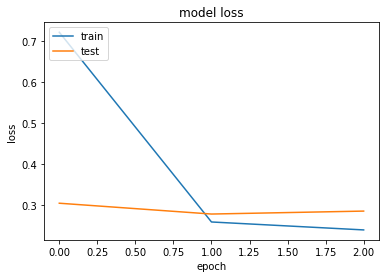

In [38]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [39]:
print('Test score:', scores_2[0]) 
print('Test accuracy:', scores_2[1]) 

Test score: 0.2856213359786246
Test accuracy: 0.9024455432791164


### Prettytable 

In [42]:
from prettytable import PrettyTable

number= [1,2]  
name= ["Model 1","Model 2"]
scr = ["0.2606", "0.2856"]
acc= ["0.9069", "0.9024"]

#Initialize Prettytable 
ptable = PrettyTable() 
ptable.add_column("Index", number) 
ptable.add_column("Model", name) 
ptable.add_column("Test Score", scr)
ptable.add_column("Test Accuracy", acc)   
print(ptable)

+-------+---------+------------+---------------+
| Index |  Model  | Test Score | Test Accuracy |
+-------+---------+------------+---------------+
|   1   | Model 1 |   0.2606   |     0.9069    |
|   2   | Model 2 |   0.2856   |     0.9024    |
+-------+---------+------------+---------------+


### Conclusions 

1. We took 50k datapoints from amazon fine food reviews.
2. We build two models to implement LSTM on Amazon fine food reviews.
3. Model 1 includes one layer of LSTM after Embedding layer.
4. Model 2 includes two layers of LSTM after Embedding layer.
5. To reduce overfitting, we used different methods like added L2 regularization in layers(LSTM & Dense), added
   Dropout layer before Dense layer, used earlystopping callback technique which monitors "val_loss".
6. Since i ran models on CPU, it took me a very long time to fit the models.
7. Batch_size for both models = 128